In [63]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
from scipy.linalg import solve_triangular


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [46]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

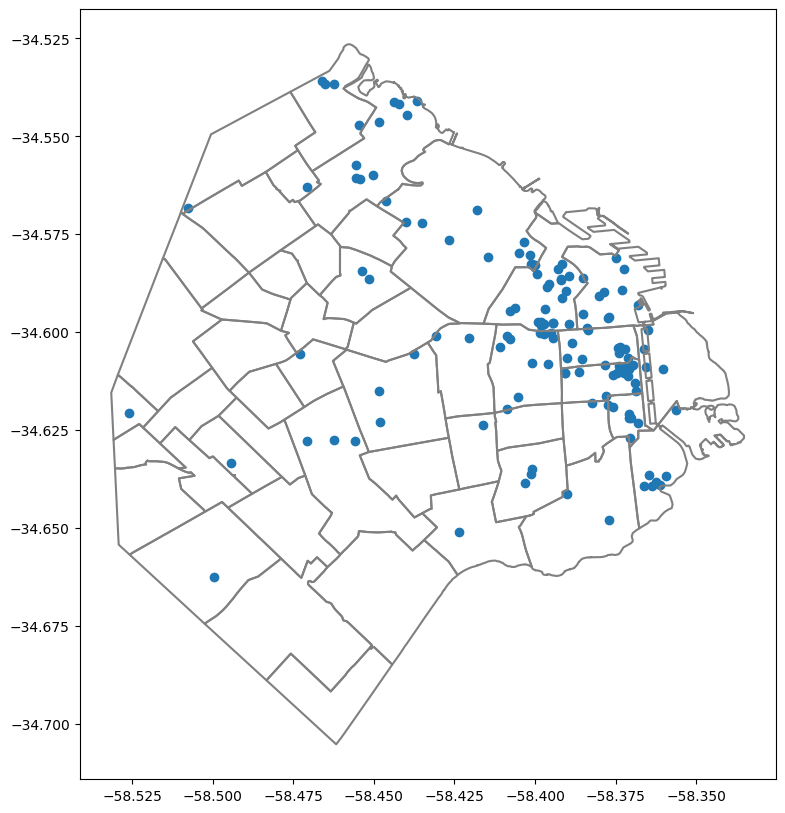

In [47]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [64]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [65]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

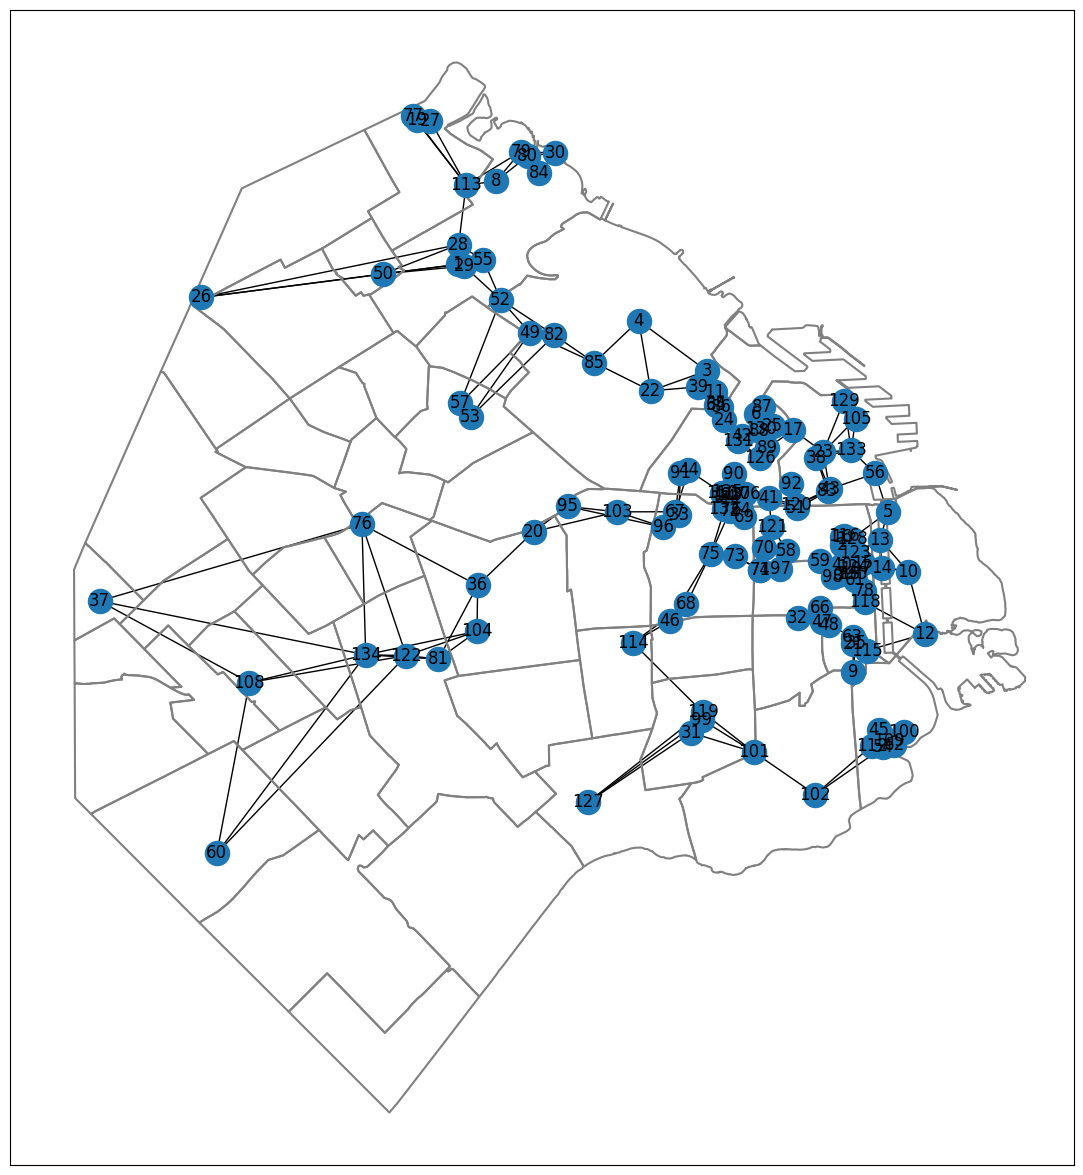

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## **Datos, fórmulas e interpretación de la introducción**  
<span style='color:green'>*(Debe haber errores, podemos ir corrigiendo...)*</span>

#### **MATRIZ DE ADYACENCIA $A$** *(o matriz de conectividad)* 

- $A \in \mathbb{R}^{n\times n},\quad n =$ cantidad de museos *(nodos)*
- $A_{ij} = $ relación entre el museo $i$ y el museo $j$
- $A_{ij} = 1$ si el museo $j$ **está entre los cercanos** al museo $i$, y vale $0$ si no lo está. Si $A_{ij} \in [0,1]$ se dice que esta **pesada** *<span style='color:#ffa869'>(la que se utiliza para construir la matriz de transición entre museos es de este tipo)</span>*. 
- En general, $A_{ij} \ne A_{ji}$, está **dirigida**.

#### **MATRIZ DE GRADO $K$**
- Es una matriz **diagonal** que contiene el número de aristas asociadas a cada vértice *(museo)*: la cantidad de conexiones de un museo, hacia cuántos otros apunta el grafo.
- $ K_{ij} = \begin{cases}   \displaystyle \sum_{h=1}^{n} A_{ih}, & \text{si } i = j \quad\text{(tiene en su diagonal la suma por filas de A)} \\ \\ 0, & \text{si } i \ne j \end{cases} $ 

#### **MATRIZ DE TRANSICIONES $C$**
- $C_{ji}$ almacena la **probabilidad de moverse desde el museo $i$ al museo $j$**.
- **Sus columnas suman 1** *(es estocástica)*.
-  Permite estudiar como es la circulación entre los museos.
- $C = A^T K^{-1}$
- Si $\vec{v}_0 \in \mathbb{R}^n$ guarda en su componente $i$ la **cantidad de visitantes** que acuden al museo $i$ al inicio de la jornada *(paso inicial $= 0$)*, entonces $\vec{v}_1 = C\vec{v}_0$.
- La **cantidad de visitantes en cada museo $i$ en el paso $k$** está en la componente $i$ del vector $\vec{v}_k = C\vec{v}_{k-1} \cdot (\ldots \cdot(C\vec{v}_0))) = C^k\vec{v}_0$

#### **PAGE RANK APLICADO A MUSEOS**
-  Representa la **probabilidad** de llegar a un museo específico después de recorrer los otros por un rato.


#### **VECTOR DE RANKINGS $\mathbf{\vec{p}}$**

- $\mathbf{\vec{p}} \in \mathbb{R}^n$
- $\mathbf{\vec{p}}_i$ contiene la **relevancia** de la página $i$ (o la **probabilidad**, en nuestro caso, de moverse desde el museo actual al museo $i$, dada por la **cercanía entre museos**).
- $\mathbf{\vec{p}}_i > 0 \;\forall \; i$
- $||\mathbf{\vec{p}}||_1 =\displaystyle \sum_{i=1}^{n}|\mathbf{\vec{p}}_i| = 1$  *(como tiene la distribución de probabilidades, sus componentes suman 1)*
- <span style='color:#00ff8c'>$\displaystyle \mathbf{\vec{p}} = (1- \alpha) \;C \mathbf{\vec{p}} \; + \frac{\alpha}{n} \vec{1}\quad$ **(ECUACIÓN 3)**</span>
  - $C$ es la matriz de transición.
  - $\vec{1}$ tiene $1$ en todas sus componentes
  - $\displaystyle ||\frac{1}{n}\vec{1}||_1 = 1$
  - $\alpha \in [0, 1]$ se denomina **factor de amortiguamiento**: representa la **probabilidad de un salto aleatorio** de una página a otra, **sin considerar el ranking de relevancia** de la página siguiente *(la cercanía entre un museo y otro)*. En nuestro caso implicaría el **fin de las visitas** a los distintos museos.
    - El **factor** $\displaystyle \frac{1}{n}$ *(el peso de cada página)* divide entre los $n$ museos la probabilidad $\alpha$ de que se interrumpan las visitas. 
    - En términos del museo, <span style='color:orange'>$\alpha>0$</span> sería  la probabilidad de que una serie de visitas se termine en un determinado momento.
    - Para <span style='color:orange'>$\alpha = 0$</span>, la componente $\mathbf{\vec{p}}_j$, es decir: $\left(\begin{array}{c} \vdots \\ \mathbf{\vec{p}}_1 C_{j1} + \ldots + \mathbf{\vec{p}}_n C_{jn} \\ \vdots  \end{array}\right)$, se vuelve la suma del producto de cada entrada de la fila $j$ de la matriz $C$ por la componente correspondiente del vector $\mathbf{\vec{p}}$, entonces:
      - $\mathbf{\vec{p}}_j = \displaystyle \sum_{i = 1}^{n}C_{ji}\mathbf{\vec{p}}_i =$ la suma de los $\mathbf{\vec{p}}_i$ que le apuntan *(**relevancia** obtenida por la relevancia de las paǵinas que le apuntan)* **pesados** por la **probabilidad** de llegar a $j$ desde $i$: de efectivamente acceder a la página *(visitar el museo $j$ cuando se está en $i$)*.


#### **CONSIDERACIONES PARA LAS VISITAS A MUSEOS**

- La mayoría de los elementos de $C$ son distintos de cero *(no es rala)*: **todas las transiciones tienen algún nivel de plausibilidad**.
- **FUNCIÓN DE DISTANCIA**: <span style='color:red'>$f(d_{ji}) = d_{ji}^{-1}$</span> recibe la distancia entre los museos $i$ y $j$ y devuelve su **inverso**, y se puede interpretar como: *qué tan atractivo (**relevante**) resulta ir a $j$ estando en $i$*. **Mientras más lejos, menos atractivo**.
- **MATRIZ DE ADYACENCIA $A$**: sus elementos son de la forma: <span style='color:#00d0ff'>$\displaystyle A_{ij} = \frac{1}{d_{ij}} \leadsto A = \left[\begin{array}{ccc}0 & \ldots &  \frac{1}{d_{1n}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{n1}} & \ldots &  0\end{array}\right] \leadsto A^T = \left[\begin{array}{ccc} 0 & \ldots &  \frac{1}{d_{n1}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{1n}} & \ldots &  0 \end{array}\right]$ </span>


- **ELEMENTOS DE LA MATRIZ DE TRANSICIÓN $C$**: sus elementos son de la forma: <span style='color:violet'>$\quad\displaystyle C_{ji} = \underbracket{P(i\to j)}_{\substack{\text{probabilidad}\\\text{de transición}\\\text{de $i$ a $j$}}} = \begin{cases} \frac{f(d_{ij})}{\displaystyle \sum_{\substack{k=1,\\ k\ne i}}^{n} f(d_{ik})}\quad \text{para $j\ne i$} \\ \\ 0 \quad \text{ para $j = i$ (no se puede ir del museo $i$ al $i$)}  \end{cases}$</span>

## **FUNCIONES (reutilizables) A COMPLETAR**

<span style='color:red'> $\downarrow$ **FUNCIONA!**  </span>

In [32]:
 # Es la que arrancamos en clase, la saqué del ejercicio 3 porque es probable que la usemos en varios lados
def calculaLU(matriz: np.ndarray) -> tuple[np.ndarray]: 
    """
    Recorre la matriz con  tres indices: k para la diagonal principal,
    i para las filas, j para las columnas. Replica el algoritmo para
    tringular pero en el lugar donde irian los ceros almacena los
    factores de eliminación gaussiana.
    Nos permite resolver (si es posible) el sistema Ax = b haciendo:
    1. L, U = calculaLU(A)
    2. y = solve_triangular(L, b, lower=True)
    3. x = solve_triangular(U, y) 
    """
    m = matriz.shape[0]
    n = matriz.shape[1]
    
    # Si no la copiamos como float da errores raros en algunos coeficientes, 
    # el que nos pasaron da bien sin la conversión, pero para otros casos nos trunca el cociente
    # y arrastra errores
    Ac = matriz.copy().astype(float)  
    if m != n:
        print('Matriz no cuadrada')
        return

    k = -1  
    while k < m-1: # Avance en diagonal
        k += 1 
        i = k 
        while i < m-1:   # Avance por filas         
            i += 1                       
            c = Ac[i][k] / Ac[k][k] # Factor de eliminación 
            j = k  # igualo a k para que empiece abajo de la diagonal (despues de la primera vuelta ya registré el factor de eliminación)
            while j < n: # Avance por columnas
                Ac[i][j] = Ac[i][j] - (c * Ac[k][j])
                j+=1                
            Ac[i][k] = c  # Registro en Ac el factor de eliminación después de usarlo en cada una de las j columnas
            
    L = np.tril(Ac,-1) + np.eye(matriz.shape[0]) 
    U = np.triu(Ac)
    
    return L, U

    
# # Ejemplos de uso para nosotros (después lo borramos)
# A1 = np.array([[1,1,1], [4,2,1], [9,3,1]])  # Ejercicio 4 de la practica 1
# b1 = np.array([1,2,0]).T
# L1, U1 = calculaLU(A1)
# y1 = solve_triangular(L1, b1, lower=True)
# x1 = solve_triangular(U1, y1) 
# print(np.allclose(L1 @ U1, A1))

# A2 = np.array([[2,3,2,4], [4,10,-4,0], [-3,-2,-5,-2], [-2,4,4,-7]])
# b2 = np.array([4,-8,-4,-1]).T
# L2, U2 = calculaLU(A2)
# y2 = solve_triangular(L2, b2, lower=True)
# x2 = solve_triangular(U2, y2) 
# print(np.allclose(L2 @ U2, A2))

True
True


<span style='color:red'> $\downarrow$ **FUNCIONA!**  </span>

Para **calcular la inversa de una matriz**, usamos lo visto en clase con respecto a **factorización LU**:

0. Si $A \in \mathbb{K}^{n\times n}$ es invertible, entonces $AA^{-1} = I = \left[\begin{array}{ccc} | & & | \\ \vec{e}_1 & \ldots & \vec{e}_n \\ | & & | \end{array}\right]$, donde $\vec{e}_j$ es el **vector canónico** que corresponde a la columna $j$ de $I$, con $1 \le j \le n$.

1. $ A = LU \implies A^{-1} = (LU)^{-1} = U^{-1}L^{-1} $

2. $A^{-1} = \left[\begin{array}{ccc} | & & | \\ \vec{x}_1 & \ldots & \vec{x}_n \\ | & & | \end{array}\right] \quad \substack{\implies \\ \text{por 0.} } \quad  A\left[\begin{array}{ccc} | & & | \\ \vec{x}_1 & \ldots & \vec{x}_n \\ | & & | \end{array}\right] = \left[\begin{array}{ccc} | & & | \\ \vec{e}_1 & \ldots & \vec{e}_n \\ | & & | \end{array}\right] \quad \implies \quad A\vec{x}_j = \vec{e}_j \quad \substack{\implies \\ \text{por 1.}} \quad LU\vec{x}_j = \vec{e}_j\;$ con $1 \le j \le n$.

3. $L\underbracket{U\vec{x}_j}_{\vec{y}_j} = \vec{e}_j \quad \leadsto \quad L\vec{y}_j = \vec{e}_j \quad$ Éste $\vec{y}_j$ lo calculamos con **sustitución hacia adelante** usando: `y_j = solve_triangular(L, e_j, lower=True)`

4. $U\vec{x}_j = \vec{y}_j \quad$ Éste $\vec{x}_j$ lo calculamos con **sustitución hacia atrás** usando: `x_j = solve_triangular(U, y_j)`

5. Luego alcanza con ubicar cada **solución** $\vec{x}_j$ en la columna $j$ de una **matriz nula** con dimensiones iguales a $A$ para obtener:  $A^{-1} = \left[\begin{array}{ccc} | & & | \\ \vec{x}_1 & \ldots & \vec{x}_n \\ | & & | \end{array}\right]$


In [62]:
def calcula_inversa_con_LU(M: np.ndarray) -> np.ndarray: 
    """
    Recibe una matriz M invertible y retorna su inversa, utilizando factorización LU.
    """
    # Verificamos que M sea cuadrada
    filas = M.shape[0]
    columnas = M.shape[1]
    if filas != columnas:
        raise ValueError('Matriz no cuadrada')

    # Verificamos que M sea invertible: podríamos ver si el número de condición es muy grande
    # o si el rango de la matriz es menor estricto que n (dimension de filas o columnas), la matriz
    # sería singular, pero no se si nos está permitido usarlo. El determinante calculo que sí.
    # Otra opción seria pedir que M sea invertible
    det_M = np.linalg.det(M)
    if np.isclose(det_M, 0):  # Si det(M) != 0, M y LU son invertibles        
        raise ValueError('Matriz no invertible')

    # Factorizamos M
    L, U = calculaLU(M)
    Minv = np.zeros((filas, columnas))  # Creamos una matriz nula que contendrá a los x_j en sus columnas
    for j in range(columnas):       
        e_j = np.zeros(filas)  # Creamos el canónico e_j
        e_j[j] = 1
        y_j = solve_triangular(L, e_j, lower=True)  # Solución de Ly_j = e_j 
        x_j = solve_triangular(U, y_j) # Solución de Ux_j = y_j         
        Minv[:, j] = x_j  # Ubicamos el vector x_j como columna j de la inversa
    return Minv
        
# prueba = np.array([[2,1,2,3], [4,3,3,4], [-2,2,-4,-12], [4,1,8,-3]])  # Ejemplo visto en el labo
# inv_prueba = calcula_inversa_con_LU(prueba)
# print(prueba @ inv_prueba)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


<span style='color:red'> $\downarrow$ **FUNCIONA!**  </span>

In [77]:
def calcula_matriz_C(A: np.ndarray) -> np.ndarray:
    """
    Calcula y retorna la matriz de trancisiones C, a partir de una matriz de adyacencia A.
    """
    sumas_filas_A = np.array([np.sum(A[i][:]) for i in range(A.shape[0])])
    inversos_de_las_sumas = 1 / sumas_filas_A 
    # K = np.diag(sumas_filas_A)  
    Kinv = np.diag(inversos_de_las_sumas) # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de A
    # print(K @ Kinv, Kinv @ K)  # Para chequear si da bien
    C = A.T @ Kinv  # Calcula C multiplicando Kinv y A (Usamos fórmula (2) dada en el TP)
    return C

# matriz_prueba = construye_adyacencia(D,3)  # D es la matriz de distancias, m la cant de museos cercanos
# C = calcula_matriz_C(matriz_prueba)
# print(np.allclose(np.diag(C), 0))

# # # Verifico que sea estocástica (la suma de sus columnas tiene que ser 1)
# sumas_columnas_C = np.array([np.sum(C[:, j]) for j in range(C.shape[1])])
# sumas_columnas_C

True


<span style='color:pink'> $\downarrow$ **EN PROCESO**  </span>

**Datos**
- $\displaystyle A_{ij} = f(d_{ij}) = \frac{1}{d_{ij}} \quad \leadsto \quad A = \left[\begin{array}{ccc} 0 & \ldots &  \frac{1}{d_{1n}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{n1}} & \ldots &  0\end{array}\right] = \left[\begin{array}{ccc} 0 & \ldots &  f(d_{1n}) \\ \vdots & \ddots & \vdots \\ f(d_{n1}) & \ldots &  0\end{array}\right] \quad \leadsto \quad A^T = \left[\begin{array}{ccc} 0 & \ldots &  \frac{1}{d_{n1}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{1n}} & \ldots &  0\end{array}\right] \quad \leadsto \quad A^T_{ij} = \begin{cases}f(d_{ji}) \quad i\ne j \\ \\ 0 \quad i=j \end{cases}$

-  $ K_{ij} = \begin{cases}   \displaystyle \sum_{h=1}^{N} A_{ih}, & \text{si } i = j \quad\text{(tiene en su diagonal la suma por filas de A)} \\ \\ 0, & \text{si } i \ne j \end{cases} $ 

- $\displaystyle C = A^T K^{-1} =  \left[\begin{array}{ccc}0 & \ldots &  \frac{1}{d_{n1}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{1n}} & \ldots & 0\end{array}\right] \left[\begin{array}{ccc}\displaystyle \frac{1}{\displaystyle\sum_{h=1}^{N} A_{ih}} & \ldots &  0 \\ \vdots & \ddots & \vdots \\ 0 & \ldots & \displaystyle  \frac{1}{\displaystyle\sum_{h=1}^{N} A_{nh}}\end{array}\right] = \left[\begin{array}{ccc}\displaystyle 0 & \ldots &  \displaystyle  \frac{1}{\displaystyle d_{n1} \cdot \sum_{h=1}^{N} A_{nh}} \\ \vdots & \ddots & \vdots \\ \displaystyle  \frac{1}{\displaystyle d_{1n} \cdot \sum_{h=1}^{N} A_{ih}} & \ldots & \displaystyle  0 \end{array}\right] \quad \leadsto \quad \quad\displaystyle C_{ij} = \begin{cases} \frac{f(d_{ji})}{\displaystyle \sum_{\substack{k=1,\\ k\ne j}}^{n} f(d_{jk})}\quad \text{para $j\ne i$} \\ \\ 0 \quad \text{ para $j = i$} \end{cases}$

- $\displaystyle \mathbf{\vec{p}} = (1- \alpha) \;C \mathbf{\vec{p}} \; + \frac{\alpha}{n} \vec{1} \quad \leadsto \quad \ldots $

- la suma de los $\mathbf{\vec{p}}_i$ que le apuntan *(**relevancia** obtenida por la relevancia de las paǵinas que le apuntan)* **pesados** por la **probabilidad** de llegar a $j$ desde $i$.

In [121]:
def calcula_pagerank(A: np.ndarray, alfa:float) -> np.ndarray:
    # Función para calcular PageRank usando LU
    # A: Matriz de adyacencia
    # d: coeficientes de damping
    # Retorna: Un vector p con los coeficientes de page rank de cada museo
    
    C = calcula_matriz_C(A)
    N = A.shape[0] # Obtenemos el número de museos N a partir de la estructura de la matriz A

    # Usamos el M notado en el Ejercicio 1: M = N/α (I - (1 - α)C)
    I = np.eye(A.shape[0], A.shape[1])
    M = N/alfa * (I - ((1 - alfa)*C))
    # Creo que d está contenido en la inversa de A y por lo tanto es factor de la matriz de transiciones
    L, U = calculaLU(M) # Calculamos descomposición LU a partir de C y d  

    
    b = ... # Vector de 1s, multiplicado por el coeficiente correspondiente usando d y N.
    Up = scipy.linalg.solve_triangular(L,b,lower=True) # Primera inversión usando L
    p = scipy.linalg.solve_triangular(U,Up) # Segunda inversión usando U
    return p

alfa_prueba = 0.5
A_prueba = construye_adyacencia(D,3)  # D es matriz de distancias, m cant de museos cercanos
print(calcula_pagerank(A_prueba, alfa_prueba))

<span style='color:yellow'> $\downarrow$ **FALTA TERMINAR!**  </span>

In [ ]:
def calcula_matriz_C_continua(D): 
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C en versión continua
    D = D.copy()
    F = 1/D
    np.fill_diagonal(F,0)
    Kinv = ... # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de F 
    C = ... # Calcula C multiplicando Kinv y F
    return C



<span style='color:yellow'> $\downarrow$ **FALTA TERMINAR!**  </span>

In [ ]:
def calcula_B(C,cantidad_de_visitas):
    # Recibe la matriz T de transiciones, y calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes
    # suponiendo que cada visitante realizó cantidad_de_visitas pasos
    # C: Matirz de transiciones
    # cantidad_de_visitas: Cantidad de pasos en la red dado por los visitantes. Indicado como r en el enunciado
    # Retorna:Una matriz B que vincula la cantidad de visitas w con la cantidad de primeras visitas v
    B = np.eye(C.shape[0])
    for i in range(cantidad_de_visitas-1):
        # Sumamos las matrices de transición para cada cantidad de pasos
    return B

## Punto 1:

### Primer intento:
1. Por la **Ecuación 3** sabemos que $$\displaystyle \mathbf{\vec{p}} = (1- \alpha) \;C \mathbf{\vec{p}} \; + \frac{\alpha}{n} \vec{1}$$

2. Queremos ver que verifica: $$M\mathbf{\vec{p}} = \vec{b}, \text{ donde } \displaystyle M = \frac{n}{\alpha}(I - (1-\alpha)C) \text{ y además } \vec{b} = \vec{1}$$

3. Usando la ecuación 3 tenemos que: $$ \displaystyle \frac{n}{\alpha}(I - (1-\alpha)C) \left( (1- \alpha) \;C \mathbf{\vec{p}} \; + \frac{\alpha}{n} \vec{1} \right) = \vec{1} \quad \leadsto \quad \underbracket{(I - (1-\alpha)C)}_{\text{matriz } R} \left( \underbracket{(1- \alpha) \;C \mathbf{\vec{p}}}_{\text{vector } v} \; + \underbracket{\frac{\alpha}{n} \vec{1}}_{\text{vector } w} \right) = \underbracket{\frac{\alpha}{n}\vec{1}}_{\text{vector } w} $$

4. $$ Rv + Rw = w \quad \leadsto \quad Rv = w - Rw \quad \substack{\longrightarrow\\ \vec{w}\; = \; I\vec{w}} \quad  Rv = (I - R)w$$

5. $$(I - (1-\alpha)C) \cdot (1- \alpha) \;C \mathbf{\vec{p}} = (\cancel{I} - (\cancel{I} - (1- \alpha) \;C))\frac{\alpha}{n}\vec{1} $$

6. $$(I - (1-\alpha)C) \cdot \cancel{(1- \alpha) \;C} \mathbf{\vec{p}} = \cancel{(1- \alpha) \;C} \frac{\alpha}{n}\vec{1} $$

7. $$(I - (1-\alpha)C) \cdot \mathbf{\vec{p}} =  \frac{\alpha}{n}\vec{1} $$

8. $$ \mathbf{\vec{p}} - (1-\alpha)C\mathbf{\vec{p}} =  \frac{\alpha}{n}\vec{1} $$

9. $$\displaystyle \mathbf{\vec{p}} = (1- \alpha) \;C \mathbf{\vec{p}} \; + \frac{\alpha}{n} \vec{1}$$

Ésta es justamente la ecuación que tienen que cumplir los vectores de ranking $\mathbf{\vec{p}}$ Dimos una vuelta en circulo, probablemente por la forma misma en que está definido $\mathbf{\vec{p}}$, o porque partimos de lo que queríamos demostrar.



### Segundo intento:
1. Por la **Ecuación 3** sabemos que $$\displaystyle \mathbf{\vec{p}} = (1- \alpha) \;C \mathbf{\vec{p}} \; + \frac{\alpha}{n} \vec{1}$$

2. Queremos ver que $\mathbf{\vec{p}}$ verifica: $$M\mathbf{\vec{p}} = \vec{b}, \text{ donde } \displaystyle M = \frac{n}{\alpha}(I - (1-\alpha)C) \text{ y además } \vec{b} = \vec{1}, \text{ para $\alpha\ne 0$}$$


3. Entonces, tenemos que: $$\displaystyle \mathbf{\vec{p}} - (1- \alpha) \;C \mathbf{\vec{p}} \; = \frac{\alpha}{n} \vec{1} \quad \substack{\longrightarrow\\ \vec{w}\; = \; I\vec{w}} \quad (I - (1- \alpha) \;C) \mathbf{\vec{p}} \; = \frac{\alpha}{n} \vec{1}$$

4. $$ \displaystyle  \frac{n}{\alpha} (I - (1- \alpha) \;C) \mathbf{\vec{p}} \; = \cancel{\frac{n}{\alpha} \frac{\alpha}{n}} \vec{1}$$

5. $$ \displaystyle  \underbracket{\frac{n}{\alpha} (I - (1- \alpha) \;C)}_{M} \mathbf{\vec{p}} \; = \underbracket{\vec{1}}_{\vec{b}}$$

6. Usando la ecuación 3 obtuvimos que cuando $\alpha\ne 0$: $$ M\mathbf{\vec{p}} = \vec{b}$$


**Conclusión**: los $\mathbf{\vec{p}}$ que cumplen la ecuación 3 para vectores de **ranking** cuando $0 < \alpha < 1$, permiten definir una matriz $M$ que contiene la información de la **matriz de transiciones** $C$, de manera que $\mathbf{\vec{p}}$ sea solución del sistema $M \mathbf{\vec{p}} = \vec{b}$. Cuando $\alpha = 1$ se pierde toda la información contenida en $C$.

## Punto 2:


## Punto 3:

## Punto 4:

## Punto 5:

## Punto 6:

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, '5'),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, '12'),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 

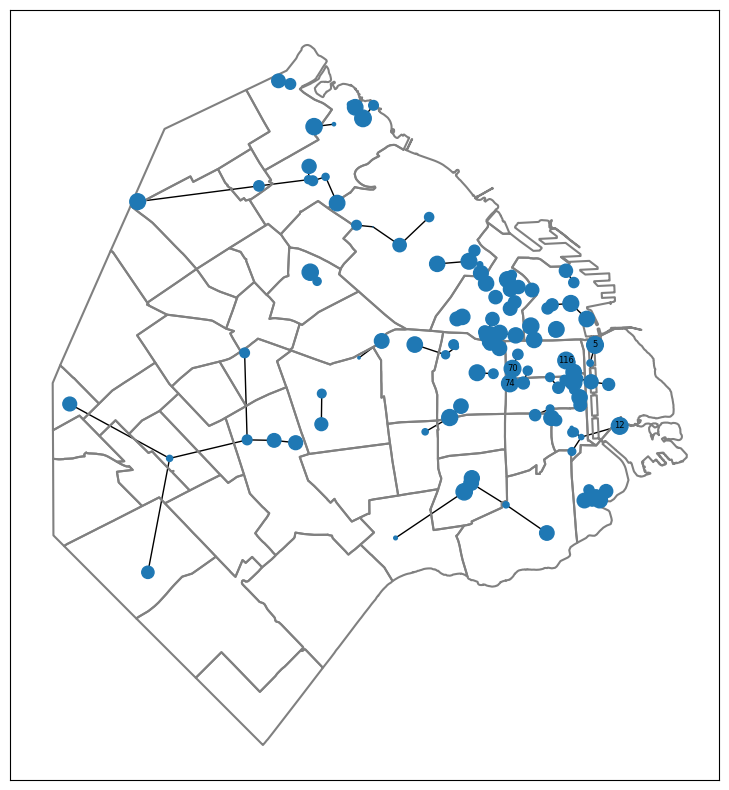

In [16]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres